# 16장. 순환 신경망으로 시퀀스 데이터 모델링

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/python-machine-learning-book-2nd-edition/blob/master/code/ch16/ch16.ipynb"><img src="https://jupyter.org/assets/main-logo.svg" width="28" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-2nd-edition/blob/master/code/ch16/ch16.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

`watermark`는 주피터 노트북에 사용하는 파이썬 패키지를 출력하기 위한 유틸리티입니다. `watermark` 패키지를 설치하려면 다음 셀의 주석을 제거한 뒤 실행하세요.

In [1]:
#!pip install watermark

In [2]:
%load_ext watermark
%watermark -u -d -v -p numpy,scipy,pyprind,tensorflow

last updated: 2019-06-12 

CPython 3.7.3
IPython 7.5.0

numpy 1.16.3
scipy 1.2.1
pyprind 2.11.2
tensorflow 2.0.0-beta0


**이 노트북을 실행하려면 텐서플로 2.0.0-alpha0 버전 이상이 필요합니다. 이전 버전의 텐서플로가 설치되어 있다면 다음 셀의 주석을 제거한 뒤 실행하세요.**

In [3]:
#!pip install tensorflow==2.0.0-alpha0

**코랩을 사용할 때는 다음 셀의 주석을 제거하고 GPU 버전의 텐서플로 2.0.0-alpha0 버전을 설치하세요.**

In [4]:
#!pip install tensorflow-gpu==2.0.0-alpha0

**코랩을 사용할 때는 다음 셀의 주석을 제거하고 실행하세요.**

In [5]:
#!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch16/movie_data.csv.gz

In [6]:
import gzip


with gzip.open('movie_data.csv.gz') as f_in, open('movie_data.csv', 'wb') as f_out:
    f_out.writelines(f_in)

# 텐서플로의 케라스 API로 시퀀스 모델링을 위한 다층 RNN 구현하기

## 첫 번째 프로젝트 - 다층 RNN으로 IMDb 영화 리뷰의 감성 분석 수행하기

### 데이터 준비

`pyprind`는 주피터 노트북에서 진행바를 출력하기 위한 유틸리티입니다. `pyprind` 패키지를 설치하려면 다음 셀의 주석을 제거한 뒤 실행하세요.

In [7]:
#!pip install pyprind

In [8]:
import pyprind
import pandas as pd
from string import punctuation
import re
import numpy as np


df = pd.read_csv('movie_data.csv', encoding='utf-8')
print(df.head(3))

                                              review  sentiment
0  In 1974, the teenager Martha Moxley (Maggie Gr...          1
1  OK... so... I really like Kris Kristofferson a...          0
2  ***SPOILER*** Do not read this, if you think a...          0


In [9]:
## 데이터 전처리:
## 단어를 나누고 등장 횟수를 카운트합니다.

from collections import Counter


counts = Counter()
pbar = pyprind.ProgBar(len(df['review']),
                       title='단어의 등장 횟수를 카운트합니다.')
for i,review in enumerate(df['review']):
    text = ''.join([c if c not in punctuation else ' '+c+' ' \
                    for c in review]).lower()
    df.loc[i,'review'] = text
    pbar.update()
    counts.update(text.split())

단어의 등장 횟수를 카운트합니다.
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:05:07


In [10]:
## 고유한 각 단어를 정수로 매핑하는
## 딕셔너리를 만듭니다.

word_counts = sorted(counts, key=counts.get, reverse=True)
print(word_counts[:5])
word_to_int = {word: ii for ii, word in enumerate(word_counts, 1)}


mapped_reviews = []
pbar = pyprind.ProgBar(len(df['review']),
                       title='리뷰를 정수로 매핑합니다.')
for review in df['review']:
    mapped_reviews.append([word_to_int[word] for word in review.split()])
    pbar.update()

리뷰를 정수로 매핑합니다.


['the', '.', ',', 'and', 'a']


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


In [11]:
## 동일 길이의 시퀀스를 만듭니다.
## 시퀀스 길이가 200보다 작으면 왼쪽에 0이 패딩됩니다.
## 시퀀스 길이가 200보다 크면 마지막 200개 원소만 사용합니다.

sequence_length = 200  ## (RNN 공식에 있는 T 값 입니다)
sequences = np.zeros((len(mapped_reviews), sequence_length), dtype=int)
for i, row in enumerate(mapped_reviews):
    review_arr = np.array(row)
    sequences[i, -len(row):] = review_arr[-sequence_length:]

X_train = sequences[:37500, :]
y_train = df.loc[:37499, 'sentiment'].values
X_test = sequences[37500:, :]
y_test = df.loc[37500:, 'sentiment'].values

In [12]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(37500, 200) (37500,) (12500, 200) (12500,)


In [13]:
n_words = len(word_to_int) + 1
print(n_words)

102967


### 임베딩

In [14]:
from tensorflow.keras import models, layers

In [15]:
model = models.Sequential()

In [16]:
model.add(layers.Embedding(n_words, 200, 
                           embeddings_regularizer='l2'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         20593400  
Total params: 20,593,400
Trainable params: 20,593,400
Non-trainable params: 0
_________________________________________________________________


### RNN 모델 만들기

In [18]:
model.add(layers.LSTM(16))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         20593400  
_________________________________________________________________
lstm (LSTM)                  (None, 16)                13888     
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 20,607,305
Trainable params: 20,607,305
Non-trainable params: 0
_________________________________________________________________


### 감성 분석 RNN 모델 훈련하기

In [20]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['acc'])

In [21]:
import time
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

callback_list = [ModelCheckpoint(filepath='sentiment_rnn_checkpoint.h5',
                                 monitor='val_loss', 
                                 save_best_only=True), 
                 TensorBoard(log_dir="sentiment_rnn_logs/{}".format(
                     time.asctime()))]

In [22]:
history = model.fit(X_train, y_train, 
                    batch_size=64, epochs=10, 
                    validation_split=0.3, callbacks=callback_list)

W0612 12:03:12.390927 140492799743808 deprecation.py:323] From /home/haesun/anaconda3/envs/python-ml/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/home/haesun/anaconda3/envs/python-ml/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:353: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 26250 samples, validate on 11250 samples
Epoch 1/10
   64/26250 [..............................] - ETA: 6:21 - loss: 172.2659 - acc: 0.5469

W0612 12:03:16.100094 140492799743808 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (0.755238). Check your callbacks.


26250/26250 [==============================] - 210s 8ms/sample - loss: 6.5555 - acc: 0.6792 - val_loss: 0.7361 - val_acc: 0.7698
Epoch 2/10
26250/26250 [==============================] - 207s 8ms/sample - loss: 0.6558 - acc: 0.8162 - val_loss: 0.6581 - val_acc: 0.8232
Epoch 3/10
26250/26250 [==============================] - 207s 8ms/sample - loss: 0.5867 - acc: 0.8427 - val_loss: 0.5448 - val_acc: 0.8611
Epoch 4/10
26250/26250 [==============================] - 207s 8ms/sample - loss: 0.5534 - acc: 0.8528 - val_loss: 0.5948 - val_acc: 0.8419
Epoch 5/10
26250/26250 [==============================] - 207s 8ms/sample - loss: 0.5245 - acc: 0.8618 - val_loss: 0.5161 - val_acc: 0.8717
Epoch 6/10
26250/26250 [==============================] - 207s 8ms/sample - loss: 0.4987 - acc: 0.8717 - val_loss: 0.4935 - val_acc: 0.8695
Epoch 7/10
26250/26250 [==============================] - 207s 8ms/sample - loss: 0.4805 - acc: 0.8820 - val_loss: 0.5439 - val_acc: 0.8675
Epoch 8/10
26250/26250 [=======

In [23]:
import matplotlib.pyplot as plt

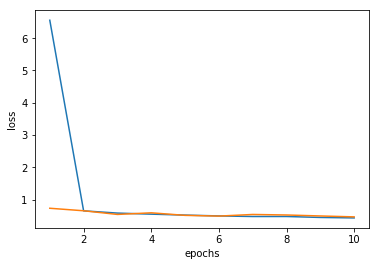

In [24]:
epochs = np.arange(1, 11)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

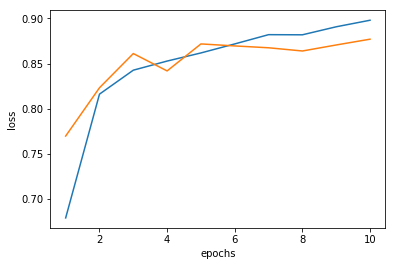

In [25]:
epochs = np.arange(1, 11)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### 감성 분석 RNN 모델 평가하기

In [26]:
model.load_weights('sentiment_rnn_checkpoint.h5')
model.evaluate(X_test, y_test)

12500/12500 [==============================] - 45s 4ms/sample - loss: 0.4828 - acc: 0.8694


[0.4827730593299866, 0.86936]

In [27]:
model.predict_proba(X_test[:10])

array([[0.00461888],
       [0.01090416],
       [0.00166053],
       [0.8800578 ],
       [0.9742082 ],
       [0.94933444],
       [0.01869908],
       [0.84085083],
       [0.006808  ],
       [0.46146366]], dtype=float32)

In [28]:
model.predict_classes(X_test[:10])

array([[0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0]], dtype=int32)

## 두 번째 프로젝트 – 텐서플로로 글자 단위 언어 모델 구현하기

### 데이터 전처리

**코랩을 사용할 때는 다음 셀의 주석을 제거하고 실행하세요.**

In [29]:
#!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch16/pg2265.txt

In [30]:
import numpy as np


## 텍스트를 읽고 처리합니다.
with open('pg2265.txt', 'r', encoding='utf-8') as f: 
    text=f.read()

text = text[15858:]
chars = set(text)
char2int = {ch:i for i,ch in enumerate(chars)}
int2char = dict(enumerate(chars))
text_ints = np.array([char2int[ch] for ch in text], 
                     dtype=np.int32)

In [31]:
len(text)

162849

In [32]:
len(chars)

65

In [33]:
def reshape_data(sequence, batch_size, num_steps):
    mini_batch_length = batch_size * num_steps
    num_batches = int(len(sequence) / mini_batch_length)
    if num_batches*mini_batch_length + 1 > len(sequence):
        num_batches = num_batches - 1
    ## 전체 배치에 포함되지 않는 시퀀스 끝부분은 삭제합니다.
    x = sequence[0 : num_batches*mini_batch_length]
    y = sequence[1 : num_batches*mini_batch_length + 1]
    ## x와 y를 시퀀스 배치의 리스트로 나눕니다.
    x_batch_splits = np.split(x, batch_size)
    y_batch_splits = np.split(y, batch_size)
    ## 합쳐진 배치 크기는
    ## batch_size x mini_batch_length가 됩니다.
    x = np.stack(x_batch_splits)
    y = np.stack(y_batch_splits)
    
    return x, y

In [34]:
## 테스트
train_x, train_y = reshape_data(text_ints, 64, 10)
print(train_x.shape)
print(train_x[0, :10])
print(train_y[0, :10])
print(''.join(int2char[i] for i in train_x[0, :10]))
print(''.join(int2char[i] for i in train_y[0, :10]))

(64, 2540)
[50  6 56 27 50 26 31 42 56  7]
[ 6 56 27 50 26 31 42 56  7 57]
The Traged
he Tragedi


In [35]:
def create_batch_generator(data_x, data_y, num_steps):
    batch_size, tot_batch_length = data_x.shape[0:2]   
    num_batches = int(tot_batch_length/num_steps)
    for b in range(num_batches):
        yield (data_x[:, b*num_steps: (b+1)*num_steps], 
               data_y[:, b*num_steps: (b+1)*num_steps])

In [36]:
bgen = create_batch_generator(train_x[:,:100], train_y[:,:100], 15)
for x, y in bgen:
    print(x.shape, y.shape, end='  ')
    print(''.join(int2char[i] for i in x[0,:]).replace('\n', '*'), '    ',
          ''.join(int2char[i] for i in y[0,:]).replace('\n', '*'))

(64, 15) (64, 15)  The Tragedie of      he Tragedie of 
(64, 15) (64, 15)   Hamlet**Actus       Hamlet**Actus P
(64, 15) (64, 15)  Primus. Scoena       rimus. Scoena P
(64, 15) (64, 15)  Prima.**Enter B      rima.**Enter Ba
(64, 15) (64, 15)  arnardo and Fra      rnardo and Fran
(64, 15) (64, 15)  ncisco two Cent      cisco two Centi


In [37]:
batch_size = 64
num_steps = 100 
train_x, train_y = reshape_data(text_ints, batch_size, num_steps)
print(train_x.shape, train_y.shape)

(64, 2500) (64, 2500)


In [38]:
from tensorflow.keras.utils import to_categorical

train_encoded_x = to_categorical(train_x)
train_encoded_y = to_categorical(train_y)
print(train_encoded_x.shape, train_encoded_y.shape)

(64, 2500, 65) (64, 2500, 65)


In [39]:
print(np.max(train_x), np.max(train_y))

64 64


### 글자 단위 RNN 모델 만들기

In [40]:
char_model = models.Sequential()

In [41]:
num_classes = len(chars)

char_model.add(layers.LSTM(128, input_shape=(None, num_classes), 
                           return_sequences=True))
char_model.add(layers.TimeDistributed(layers.Dense(num_classes, 
                                                   activation='softmax')))

In [42]:
char_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 128)         99328     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 65)          8385      
Total params: 107,713
Trainable params: 107,713
Non-trainable params: 0
_________________________________________________________________


### 글자 단위 RNN 모델 훈련하기

In [43]:
from tensorflow.keras.optimizers import Adam

adam = Adam(clipnorm=5.0)

In [44]:
char_model.compile(loss='categorical_crossentropy', optimizer=adam)

In [45]:
callback_list = [ModelCheckpoint(filepath='char_rnn_checkpoint.h5')] 

In [46]:
for i in range(500):
    bgen = create_batch_generator(train_encoded_x, 
                                  train_encoded_y, num_steps)
    char_model.fit_generator(bgen, steps_per_epoch=25, epochs=1, 
                             callbacks=callback_list, verbose=0)

### 글자 단위 RNN 모델로 텍스트 생성하기

In [47]:
np.random.seed(42)

def get_top_char(probas, char_size, top_n=5):
    p = np.squeeze(probas)
    p[np.argsort(p)[:-top_n]] = 0.0
    p = p / np.sum(p)
    ch_id = np.random.choice(char_size, 1, p=p)[0]
    return ch_id

In [48]:
seed_text = "The "
for ch in seed_text:
    num = [char2int[ch]]
    onehot = to_categorical(num, num_classes=65)
    onehot = np.expand_dims(onehot, axis=0)
    probas = char_model.predict(onehot)
num = get_top_char(probas, len(chars))
seed_text += int2char[num]

In [49]:
for i in range(500):
    onehot = to_categorical([num], num_classes=65)
    onehot = np.expand_dims(onehot, axis=0)
    probas = char_model.predict(onehot)
    num = get_top_char(probas, len(chars))
    seed_text += int2char[num]
print(seed_text)

The me  thou ate th m. m.
Sanco  t,

Tisthe todingr  te wilithor t mu t te this athou mort as t are  mond m. therondis wine asth me torthastourestorthe thind wo anco arourod atongouren t wo we this m. wis thilongh  art the wilorthine angat thenes mou wisthind wilo wo wis mue winge ay m.
 to t,

Th  angho  ay  mer this mathe ane   mure,


To to the athe withe, wer.  wes thodo thit the wisthe werere me t  w we, thie an me ayo toreronclonchishour wie mou menghe,

 arert te, t  whes ar are,
Tingro m.
Tis
